# Project: Time Series - Forecasting the number of Air Passengers
**Marks: 30**

Dear Learner,

Welcome to project on Time Series. We will use the Air Passengers for the exercise.
Do read the problem statement and the guidelines around the same.

----
## Context: 
-------

This dataset provides monthly totals of a US airline passengers (in thousands) from the period of 1949 to 1960. This dataset is taken from an inbuilt dataset of R called AirPassengers.

---------
## Objective:
------------
You are a data scientist for this airline and they want to forecast the monthly number of passengers for the next 24 months (i.e for the period of 1961-1962) to balance their manpower hiring and decision on the additional/alteration in the existing and new routes. This forecast will also help the airline to set their dynamic pricing according to the need.

--------
## Attributes Information:
------------
- 'Year-Month' ----> Month and Year starting from 01-01-1949
- '# Passengers' ----> Total number of passengers for a particular month

---------------------------
## Guidelines
-----------------------------------------
- The exercise consists of semi written code blocks. You need to fill the blocks (_______) as per the instructions to achieve the required results.
- To be able to complete the assessment in the expected time, do not change the variable names. The codes might throw errors when the names are changed. 
- The marks of each requirement is mentioned in the question.
- You can raise your issues on the discussion forum on Olympus.
- You can use Jupyter Notebook/ Google Colab(recommended) for this assessment.
--------------------------------------------
Wishing you all the best!

### Import libraries

In [1]:
# To ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing libraries for data manipulation
import pandas as pd
import numpy as np

#Importing libraries for visualization
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

#Importing library for date manipulation
from datetime import datetime

### Reading the dataset

In [3]:
#Reading the dataset
df = pd.read_excel('AirPassenger.xlsx')
df.head()

,Year-Month,# Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
#Check the shape of the dataset
df.shape

(144, 2)

In [5]:
#Setting the date as an index to make the dataset with only one column

df['Year-Month'] = pd.to_datetime(df['Year-Month'], infer_datetime_format=True)
df = df.set_index(['Year-Month'])
df.head(12)


,# Passengers
Year-Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


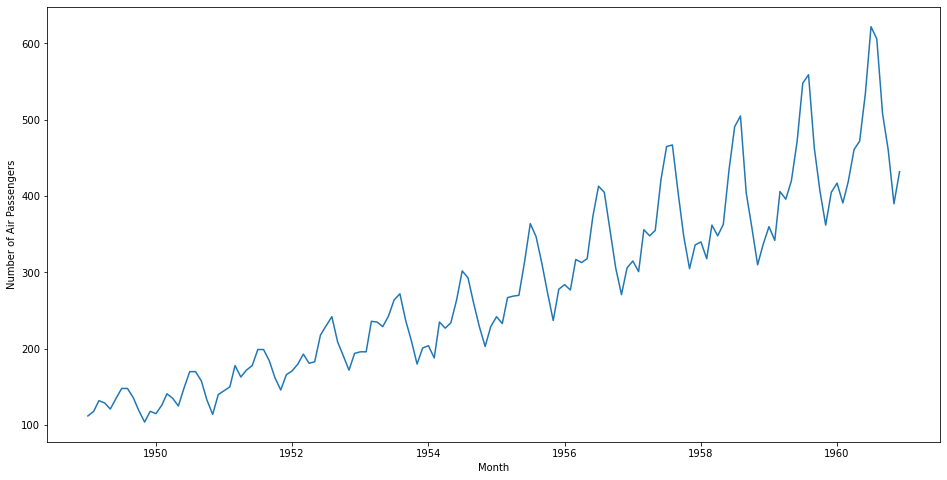

In [6]:
# Visualizing the time series dataset
plt.figure(figsize=(16,8))
plt.xlabel("Month")
plt.ylabel("Number of Air Passengers")
plt.plot(df)

**Observations**
- We can see that the series has a upward trend with some seasonality
- Before modelling with AR, MA or ARMA, we need to check whether the series is stationary or not
- Let us first check the rolling mean and standard deviation of the series if we can visualize any trend or seasonality

### Calculating and Visualizing the rolling mean & standard deviation of the series (for 12 observations) to check the stationarity of the time series (2 marks)

In [7]:
# Calculating the rolling mean and standard deviation for a window of 12 observations
rolmean=df.rolling(window=12).mean()    #calculate the mean here
rolstd=df.rolling(window=12).std()     #calculate the standard deviation here
print(rolmean.head(15))
print('**************************************')
print('**************************************')
print(rolstd.head(15))


            # Passengers
Year-Month              
1949-01-01           NaN
1949-02-01           NaN
1949-03-01           NaN
1949-04-01           NaN
1949-05-01           NaN
1949-06-01           NaN
1949-07-01           NaN
1949-08-01           NaN
1949-09-01           NaN
1949-10-01           NaN
1949-11-01           NaN
1949-12-01    126.666667
1950-01-01    126.916667
1950-02-01    127.583333
1950-03-01    128.333333
**************************************
**************************************
            # Passengers
Year-Month              
1949-01-01           NaN
1949-02-01           NaN
1949-03-01           NaN
1949-04-01           NaN
1949-05-01           NaN
1949-06-01           NaN
1949-07-01           NaN
1949-08-01           NaN
1949-09-01           NaN
1949-10-01           NaN
1949-11-01           NaN
1949-12-01     13.720147
1950-01-01     13.453342
1950-02-01     13.166475
1950-03-01     13.686977


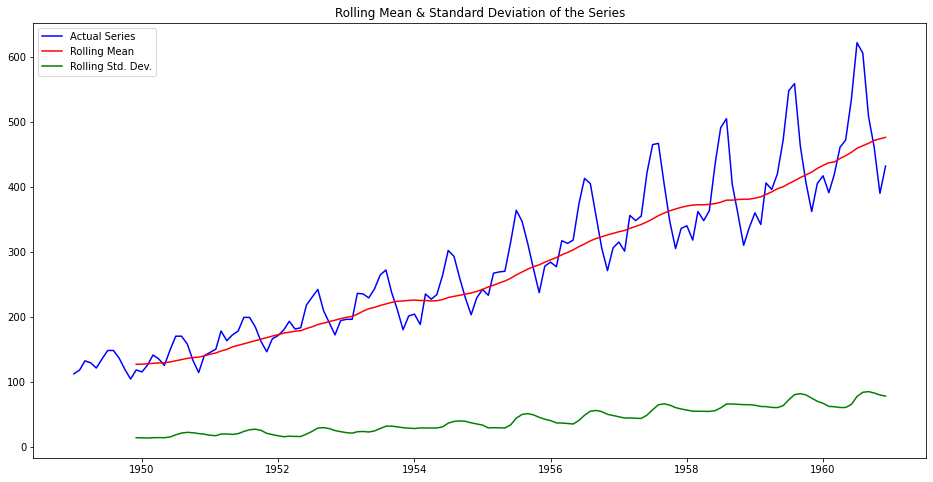

In [8]:
#Visualizing the rolling mean and standard deviation

plt.figure(figsize=(16,8))
actual = plt.plot(df, color='blue', label='Actual Series')     #fill the dataframe name
rollingmean = plt.plot(rolmean, color='red', label='Rolling Mean')    #fill the dataframe name 
rollingstd = plt.plot(rolstd, color='green', label='Rolling Std. Dev.')   #fill the dataframe name
plt.title('Rolling Mean & Standard Deviation of the Series')
plt.legend()
plt.show()

**Observations:**
- The rolling mean shows that there is an increasing trend in the data over the years.
- The time series shows an increasing trend over the years, and seasonality.
- The rolling standard deviation does not change much over the years.

### Testing the stationarity of the series using Augmented Dickey-Fuller Test

The hypotheses for ADF test are defined as 
-        Null hypothesis         - Time Series is non-stationary
-        Alternative hypothesis  - Time Series is stationary

In [9]:
#Define a function to use adfuller test
def adfuller(df):
  #Importing adfuller using statsmodels
  from statsmodels.tsa.stattools import adfuller
  print('Dickey-Fuller Test: ')
  adftest = adfuller(df['# Passengers'])
  adfoutput = pd.Series(adftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Observations'])
  for key,value in adftest[4].items():
    adfoutput['Critical Value (%s)'%key] = value
  print(adfoutput)
adfuller(df)

Dickey-Fuller Test: 
Test Statistic            0.815369
p-value                   0.991880
Lags Used                13.000000
No. of Observations     130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


**Observations**
1. From the above test, we see that the p-value = 0.991880 i.e. > 0.1 (For 90% confidence intervals) therefore, we fail to reject the null hypothesis.
2. Hence, we can confirm that the series is non-stationary

### Making the series stationary (5 marks)

We can use the following methods to make a non-stationary series to stationary.
1. Log transformation
2. Differencing
3. By shifting the series (lagged series)

Let's first use the log transformation over this series to remove exponential variance and again check the stationarity of the series

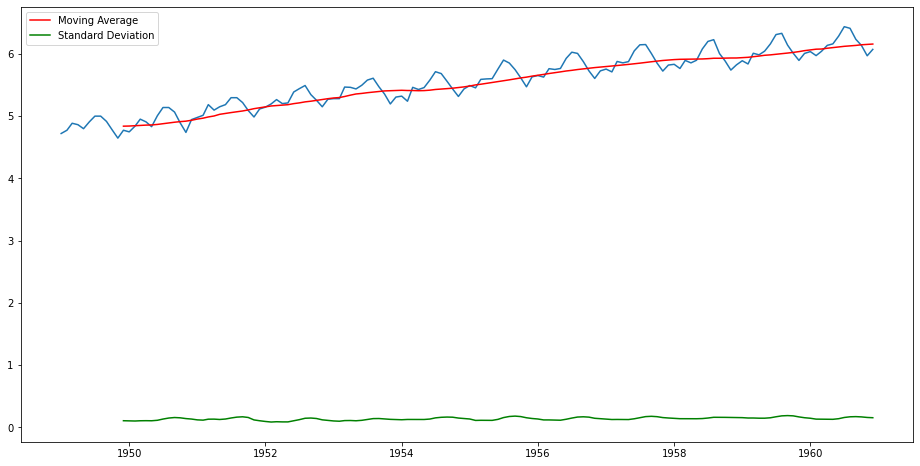

In [10]:
# Visualize the rolling mean and standard deviation after using log transformation
plt.figure(figsize=(16,8))
df_log = np.log(df)
MAvg = df_log.rolling(window=12).mean()   #calculate the mean
MStd = df_log.rolling(window=12).std()   #calculate the standard deviation
plt.plot(df_log)                            #plot the dataframe with log transformation
plt.plot(MAvg, color='r', label = 'Moving Average')   #plot the moving average of the dataframe with log transformation
plt.plot(MStd, color='g', label = 'Standard Deviation')   #plot the standard deviation of the dataframe with log transformation
plt.legend()
plt.show()

In [11]:
df_log

,# Passengers
Year-Month,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791
...,...
1960-08-01,6.406880
1960-09-01,6.230481
1960-10-01,6.133398


In [12]:
MAvg.head(12)

,# Passengers
Year-Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
1949-06-01,NaN
1949-07-01,NaN
1949-08-01,NaN
1949-09-01,NaN


**Observations:**

- The log of the series shows an increasing trend. 
- The rolling mean appears to show an approximately linear increase over the years.
- The rolling standard deviation does not change much over the years.

Let's use differencing method over the series to remove temporal dependence (trend) and again check the stationarity of the series

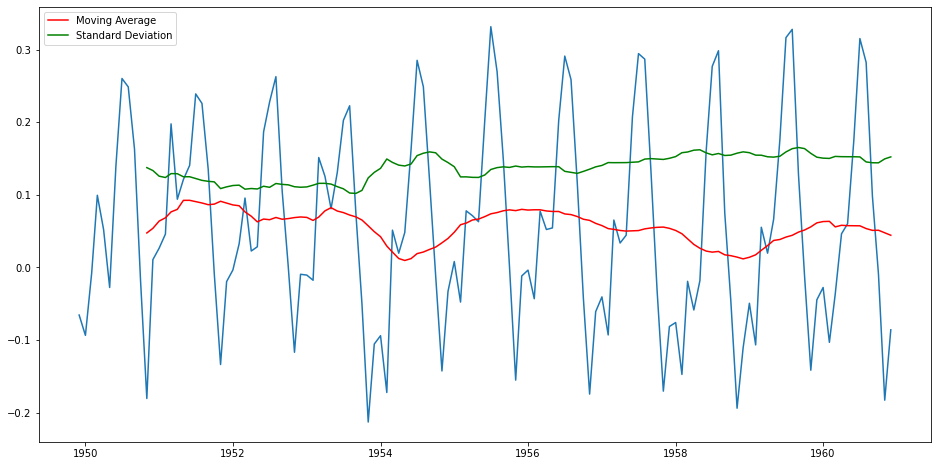

In [13]:
# Visualize the rolling mean and standard deviation after using log transform and differencing 
plt.figure(figsize=(16,8))
df_log_diff = df_log - MAvg
MAvg_diff = df_log_diff.rolling(window=12).mean()    #calculate the mean
MStd_diff = df_log_diff.rolling(window=12).std()    #calculate the standard deviation
plt.plot(df_log_diff)                                     #plot the dataframe with differencing
plt.plot(MAvg_diff, color='r', label = 'Moving Average')  #plot the moving average of the dataframe with differencing
plt.plot(MStd_diff, color='g', label = 'Standard Deviation') #plot the standard deviation of the dataframe with differencing
plt.legend()
plt.show()

#Dropping the null values that we get after applying differencing method
df_log_diff = df_log_diff.dropna()

**Observations:**
- The transformed series appears to be stationary.
- The rolling mean does not change much over the years.
- The rolling standard deviation does not change much over the years.

In [14]:
#Using the adfuller function for df_log_diff
adfuller(df_log_diff)

Dickey-Fuller Test: 
Test Statistic           -3.162908
p-value                   0.022235
Lags Used                13.000000
No. of Observations     119.000000
Critical Value (1%)      -3.486535
Critical Value (5%)      -2.886151
Critical Value (10%)     -2.579896
dtype: float64


**Observations:**
- The p-value < 0.05, so we can reject the null hypothesis ($H_0$: the transformed time series is not stationary) with 95% confidence limits. 
- The transformed time series is now stationary.

Let's shift the series by order 1 (or by 1 month) & apply differencing (using lagged series) and then check the rolling mean and standard deviation

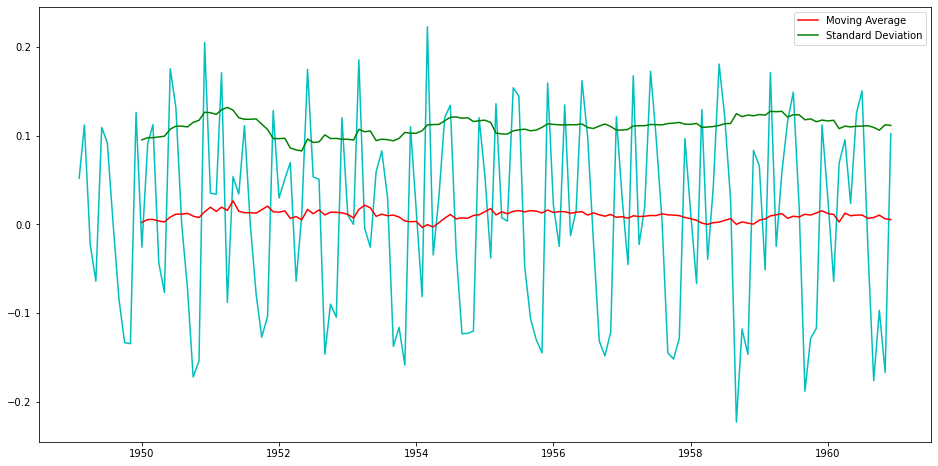

In [15]:
plt.figure(figsize=(16,8))
df_shift = df_log - df_log.shift(periods = 1)
MAvg_shift = df_shift.rolling(window=12).mean()   #calculate the mean
MStd_shift = df_shift.rolling(window=12).std()   #calculate the standard deviation
plt.plot(df_shift, color='c')                       #plot the dataframe with lag
plt.plot(MAvg_shift, color='red', label = 'Moving Average')    #plot the moving average of the dataframe with lag
plt.plot(MStd_shift, color='green', label = 'Standard Deviation')    #plot the standard deviation of the dataframe with lag
plt.legend()
plt.show()

#Dropping the null values that we get after applying diffrencing method
df_shift = df_shift.dropna()

**Observations:**
- The transformed series appears to be stationary, and there is no obvious trend seen in the rolling mean.
- The rolling mean and the rolling standard deviation do not change much over the years.

In [16]:
#Using the adfuller function for df_shift
adfuller(df_shift)

Dickey-Fuller Test: 
Test Statistic           -2.717131
p-value                   0.071121
Lags Used                14.000000
No. of Observations     128.000000
Critical Value (1%)      -3.482501
Critical Value (5%)      -2.884398
Critical Value (10%)     -2.578960
dtype: float64


**Observations:**
- p-value>0.05, so the null hypothesis ($H_0$: the shifted log time series is not stationary) cannot be rejected at the 95% confidence limit.

**Note:** *We will use the lag 1 series (df_shift) for AR, MA & ARMA models.*

### Decomposing the time series components into Trend, Seasonality and Residual (3 marks)

Let us decompose the time series to separate the components of the time series

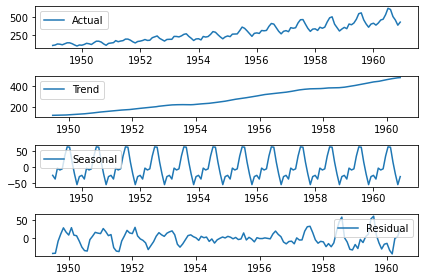

In [17]:
#Importing the seasonal_decompose to decompose the time series
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(df)      #Use the actual series to decompose

trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

plt.subplot(411)
plt.plot(df, label='Actual')
plt.legend()
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend()
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend()
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend()
plt.tight_layout()

**Observations:**

- There is a trend, which shows the number of passengers increasing over the years, and appears approximately linear.
- There is seasonality in the data. The residual between 1958 and 1960 is almost of the same magnitude and same period as the seasonality, showing that the seasonality became stronger over the years. This is seen in the plot of seasonality + residual below, which shows an increasing amplitude of oscillations over time.

Text(0.5, 0, 'Year')

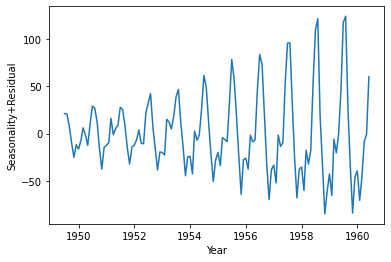

In [18]:
plt.plot(seasonal+residual)
plt.ylabel('Seasonality+Residual')
plt.xlabel('Year')

### Plotting the auto-correlation function and partial auto-correlation function to get p and q value for AR, MA and ARMA models

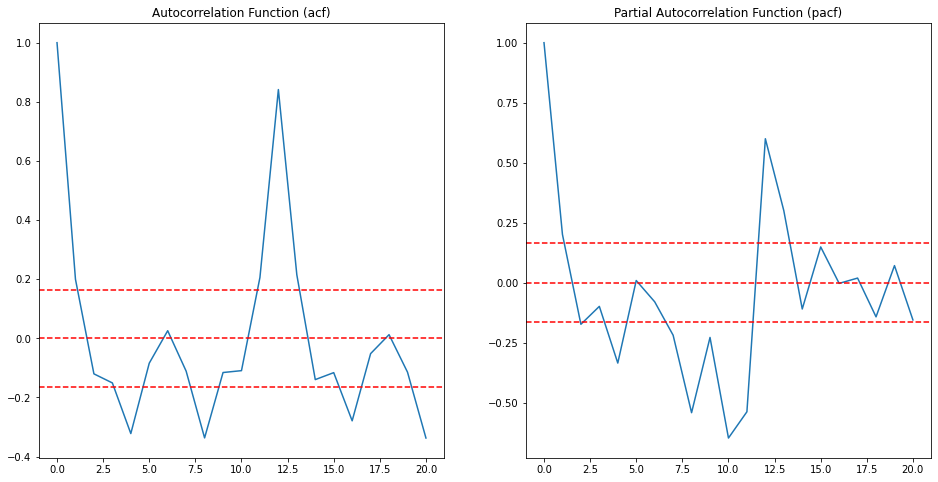

In [19]:
#Importing acf and pacf functions
from statsmodels.tsa.stattools import acf, pacf
#Using 20 lags in the series
lag_acf = acf(df_shift, nlags=20)
lag_pacf = pacf(df_shift, nlags=20, method='ols')

plt.figure(figsize=(16,8))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='red')
# 95% CI for mean, sample mean 0, std 1
plt.axhline(y=-1.96/np.sqrt(len(df_shift)),linestyle='--',color='red')
plt.axhline(y=1.96/np.sqrt(len(df_shift)),linestyle='--',color='red')
plt.title('Autocorrelation Function (acf)')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='red')
# 95% CI for mean, sample mean 0, std 1
plt.axhline(y=-1.96/np.sqrt(len(df_shift)),linestyle='--',color='red')
plt.axhline(y=1.96/np.sqrt(len(df_shift)),linestyle='--',color='red')
plt.title('Partial Autocorrelation Function (pacf)')
plt.show()

Using plot_acf, plot_pacf functions, below.

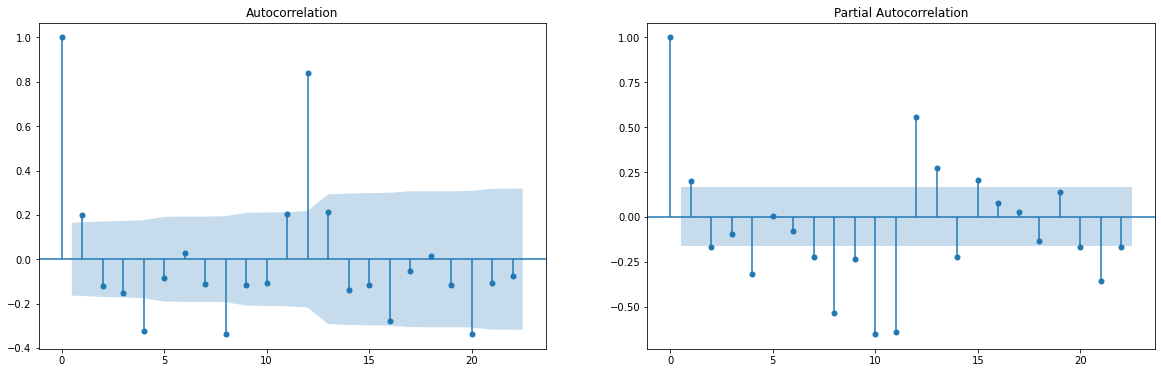

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
plot_acf(df_shift, ax=ax1)
plot_pacf(df_shift, ax=ax2)
plt.show()


**Observations**
- We can see that in both plots, the blue line is entering into the confidence interval (dotted red) at 2, therefore we will be using the values of p, q values as 2

### AR Model (3 marks)

C:\Users\Aruna\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


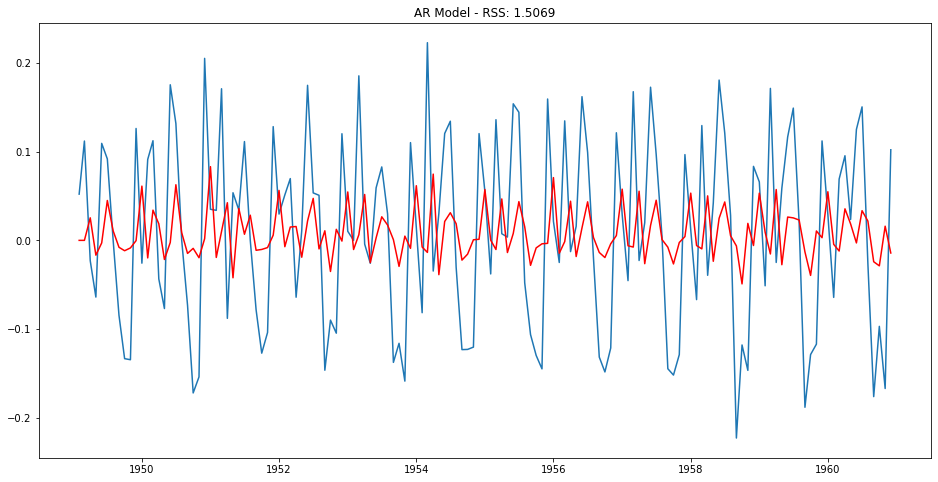

In [21]:
#Importing AutoReg function to apply AR model
from statsmodels.tsa.ar_model import AutoReg

#Comparing the actual & predicted series by AR model and calculating the Residual Sum of Squares
plt.figure(figsize=(16,8))
model_AR = AutoReg(df_shift, lags=2) #Using number of lags as 2
results_AR = model_AR.fit()
plt.plot(df_shift)   #Visualizing the actual series used for modeling
predict = results_AR.predict(start=0,end=len(df_shift)-1)
predict = predict.fillna(0) #Converting NaN values to 0
plt.plot(predict, color='red')
plt.title('AR Model - RSS: %.4f'% sum((predict-df_shift['# Passengers'])**2))   #calculate the residual sum of squares
plt.show()


**Observations**
- We can see that by using AR model, we get RSS = 1.5069
- Let us use MA and ARMA models and see if we can reduce the RSS

The calculations below are not part of the graded project. I am comparing the fitted values from the AR model to the predictions:

In [22]:
results_fit = results_AR.fittedvalues

In [23]:
from dateutil.relativedelta import relativedelta
results_fit[results_AR.fittedvalues.index[0]-relativedelta(months=1)]= 0
results_fit[results_AR.fittedvalues.index[0]-relativedelta(months=2)]= 0
results_fit.sort_index(inplace=True)
results_fit.head(5)

Year-Month
1949-02-01    0.000000
1949-03-01    0.000000
1949-04-01    0.025438
1949-05-01   -0.016715
1949-06-01   -0.002890
dtype: float64

In [24]:
predict.head(5)

1949-02-01    0.000000
1949-03-01    0.000000
1949-04-01    0.025438
1949-05-01   -0.016715
1949-06-01   -0.002890
Freq: MS, dtype: float64

In [25]:
# Sum of squares difference between fitted values and prediction:
sum( (results_fit-predict)**2)

0.0

In [26]:
# Residual sum of squares
sum( (predict-df_shift['# Passengers'])**2)

1.5068501053990586

In [27]:
# Sum of squares difference between fitted values and data series:
sum( (results_fit-df_shift['# Passengers'])**2)

1.5068501053990586

In [28]:
# AR results summary
results_AR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:           # Passengers   No. Observations:                  143
Model:                     AutoReg(2)   Log Likelihood                 120.630
Method:               Conditional MLE   S.D. of innovations              0.103
Date:                Fri, 27 Nov 2020   AIC                             -4.492
Time:                        01:20:15   BIC                             -4.409
Sample:                    04-01-1949   HQIC                            -4.458
                         - 12-01-1960                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept           0.0082      0.009      0.936      0.349      -0.009       0.025
# Passengers.L1     0.2350      0.083      2.825      0.005       0.072       0.398
# Passengers.L2    -0.1737      0.084     -2.069      0.039      -0.338      -0.009
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6764           -2.3022j            2.3995           -0.2045
AR.2            0.6764           +2.3022j            2.3995            0.2045
-----------------------------------------------------------------------------
"""

### MA Model (3 marks)

We will be using ARMA model with p=0 so that it will work as MA Model

C:\Users\Aruna\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


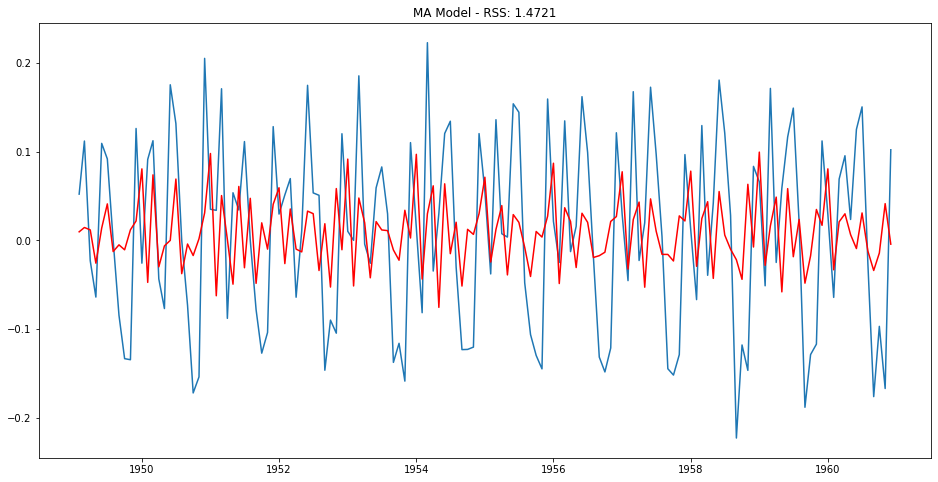

In [29]:
#Importing ARMA
from statsmodels.tsa.arima_model import ARMA

#Comparing the actual & predicted series by MA model and calculating the Residual Sum of Squares
plt.figure(figsize=(16,8))
model_MA = ARMA(df_shift, order=(0,2)) #Using p=0 and q=2
results_MA = model_MA.fit()
plt.plot(df_shift)              #Visualzing the actual series used for modelling
plt.plot(results_MA.fittedvalues, color='red')
plt.title('MA Model - RSS: %.4f'% sum( (results_MA.fittedvalues - df_shift['# Passengers'])**2))    #calculate the residual sum of squares
plt.show()

#### **Observations**
- We can see that by using MA model, we get RSS = 1.4721 i.e. lower than AR model
- Let us use ARMA model and see if we can reduce the RSS

In [30]:
# MA results summary
results_MA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           # Passengers   No. Observations:                  143
Model:                     ARMA(0, 2)   Log Likelihood                 124.189
Method:                       css-mle   S.D. of innovations              0.101
Date:                Fri, 27 Nov 2020   AIC                           -240.379
Time:                        01:20:16   BIC                           -228.528
Sample:                    02-01-1949   HQIC                          -235.563
                         - 12-01-1960                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0096      0.007      1.314      0.189      -0.005       0.024
ma.L1.# Passengers     0.2019      0.120      1.688      0.091      -0.033       0.436
ma.L2.# Passengers    -0.3409      0.188     -1.814      0.070      -0.709       0.027
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.4419           +0.0000j            1.4419            0.5000
MA.2            2.0342           +0.0000j            2.0342            0.0000
-----------------------------------------------------------------------------
"""

### ARMA Model (5 marks)

We will using p=2 and q=2 as inferred from acf and pacf

C:\Users\Aruna\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


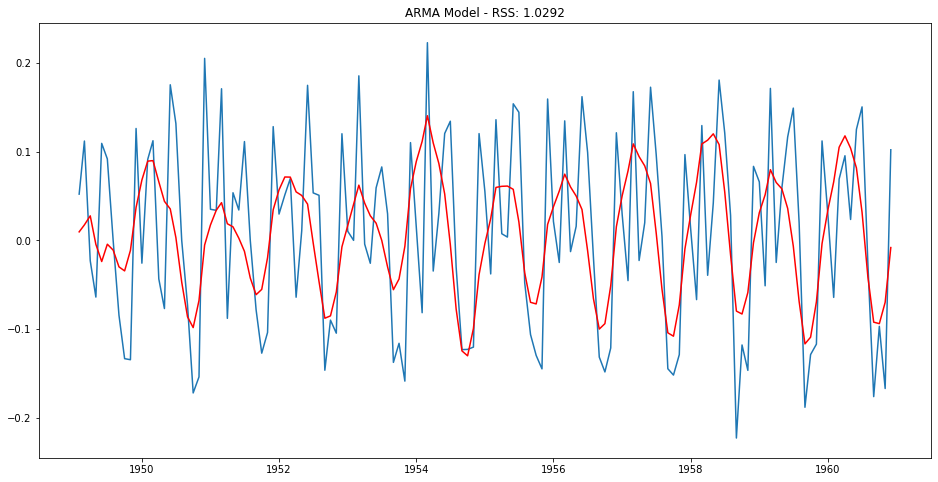

In [31]:
from statsmodels.tsa.arima_model import ARMA

#Comparing the actual & predicted series by AR model and calculating the Residual Sum of Squares
plt.figure(figsize=(16,8))
model = ARMA(df_shift, order=(2,2)) #Using p=2, q=2
results = model.fit()
plt.plot(df_shift)            #Visualizing the actual series used for modelling
plt.plot(results.fittedvalues, color='red')
plt.title('ARMA Model - RSS: %.4f'% sum((results.fittedvalues - df_shift['# Passengers'])**2))   #calculate the residual sum of squares
plt.show()  

In [32]:
print(results.summary())

                              ARMA Model Results                              
Dep. Variable:           # Passengers   No. Observations:                  143
Model:                     ARMA(2, 2)   Log Likelihood                 149.640
Method:                       css-mle   S.D. of innovations              0.084
Date:                Fri, 27 Nov 2020   AIC                           -287.281
Time:                        01:20:16   BIC                           -269.504
Sample:                    02-01-1949   HQIC                          -280.057
                         - 12-01-1960                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0096      0.003      3.697      0.000       0.005       0.015
ar.L1.# Passengers     1.6293      0.039     41.868      0.000       1.553       1.706
ar.L2.# Passengers  

In [33]:
#Printing the fitted values
predictions=pd.Series(results.fittedvalues)
predictions

Year-Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023889
                ...   
1960-08-01   -0.041176
1960-09-01   -0.092350
1960-10-01   -0.094013
1960-11-01   -0.069924
1960-12-01   -0.008127
Length: 143, dtype: float64

# **Observations:**
- We can see that by using ARMA model, we get RSS = 1.0292 i.e lesser than both AR and MA models
- Since ARMA model gives us the best RSS, we will forecast the values using ARMA

### Inverse Transformation (5 marks)

Since we now have the fitted values by ARMA model, we will use the inverse transformation to get the original values.

In [34]:
#First step - doing cumulative sum
predictions_cumsum = predictions.cumsum()    #Use the predicted values series
predictions_cumsum

Year-Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
                ...   
1960-08-01    1.372554
1960-09-01    1.280204
1960-10-01    1.186191
1960-11-01    1.116267
1960-12-01    1.108141
Length: 143, dtype: float64

In [35]:
#Second step - Adding the first value of the log series to the cumulative sum values
predictions_log = pd.Series(df_log['# Passengers'].iloc[0], index=df_log.index)
predictions_log = predictions_log.add(predictions_cumsum, fill_value=0)   #Use the series with cumulative sum
predictions_log

Year-Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
                ...   
1960-08-01    6.091053
1960-09-01    5.998703
1960-10-01    5.904690
1960-11-01    5.834766
1960-12-01    5.826639
Length: 144, dtype: float64

In [36]:
#Third step - applying exponential transformation
predictions_ARMA = np.exp(predictions_log)       #Use the series with log values
predictions_ARMA

Year-Month
1949-01-01    112.000000
1949-02-01    113.078122
1949-03-01    115.073414
1949-04-01    118.301986
1949-05-01    117.768364
                 ...    
1960-08-01    441.886419
1960-09-01    402.905896
1960-10-01    366.753491
1960-11-01    341.984796
1960-12-01    339.216796
Length: 144, dtype: float64

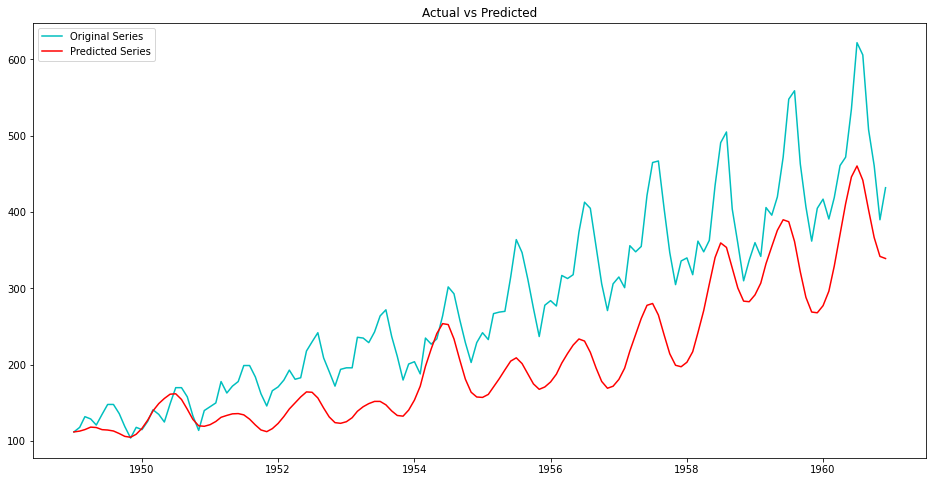

In [37]:
#Plotting the original vs predicted series
plt.figure(figsize=(16,8))
plt.plot(df, color = 'c', label = 'Original Series')
plt.plot(predictions_ARMA, color = 'r', label = 'Predicted Series')       #Use the series with predicted values
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

**Observations**
- We can see that the predicted series is very similar to that of original series
- Let us forecast the number of passengers for next 24 months

### Forecasting the number of passengers for next 24 months (4 marks)

In order to forecast the values for next 24 months, we need to follow the below steps-
1. Forecast the fitted values for next 24 months
2. Make a combined list containing the previous fitted values by ARMA model (1949-1960 and these 24 months (1961-1962) forecasted values
3. Convert that combined list into a series so that we can work with pandas functions 
4. Make a dataframe where we have the dates starting from 01-01-1949 to 12-01-1962 as the index and the respective predicted cumulative sum values
5. Add the log values of the original series in the same dataframe from 1949-1960 and 1961-1962 as NaN (since we don't know the original number of passengers for this period)
6. Applying the inverse tranformation and get the forecasted number of passengers

In [38]:
#Forecasting the values for next 24 months
predictions_ARMA = results.forecast(steps=24) # here steps represent the number of months
predictions_ARMA[0]

array([ 0.02710835,  0.05728011,  0.07161562,  0.06798134,  0.04923615,
        0.02194646, -0.00574675, -0.0264538 , -0.03541762, -0.03149825,
       -0.01709388,  0.00286844,  0.02250662,  0.03664473,  0.04211179,
        0.03837162,  0.02738727,  0.01283675, -0.00104362, -0.01064198,
       -0.01386332, -0.01052539, -0.00220534,  0.00836418])

In [39]:
#Converting the fitted values by ARMA into a list
predictions_list = predictions.tolist()
#Converting the forecasted values by ARMA into a list
predictions_ARMA_list = predictions_ARMA[0].tolist()
#combining the both lists
predictions_list.extend(predictions_ARMA_list)
predictions_list

[0.00958005678290591,
 0.017491383243360692,
 0.027670246675824378,
 -0.004520880443339474,
 -0.02388949525094386,
 -0.004346854619384277,
 -0.010977569376527864,
 -0.029928900152705336,
 -0.03446728817154082,
 -0.011278532664088625,
 0.03721213295786559,
 0.0681348663631523,
 0.08943401018341408,
 0.09002924089237734,
 0.06615172915189708,
 0.04405335562045434,
 0.03546712023805043,
 0.0031001763262412663,
 -0.047127335501036,
 -0.08635277030841697,
 -0.09846505955309062,
 -0.06784615021168589,
 -0.005227433371110646,
 0.01738487298134529,
 0.0340156570134656,
 0.04256128793560113,
 0.018747650392451506,
 0.01525989969162636,
 0.002489194711593562,
 -0.012408008629246833,
 -0.042491884907565905,
 -0.06132792108990137,
 -0.055338005636480364,
 -0.019570429333555198,
 0.03455554041370361,
 0.056975310056295844,
 0.07153405869528762,
 0.07139121300843182,
 0.0547411859688465,
 0.050661985429179435,
 0.04092782035784978,
 -0.002985971632539032,
 -0.04648267753288879,
 -0.0878964715883639,

In [40]:
#Converting the combined list into a series
predictions_list_series = pd.Series(predictions_list)
predictions_list_series

0      0.009580
1      0.017491
2      0.027670
3     -0.004521
4     -0.023889
         ...   
162   -0.010642
163   -0.013863
164   -0.010525
165   -0.002205
166    0.008364
Length: 167, dtype: float64

In [41]:
forecasted_cumsum = predictions_list_series.cumsum()
forecasted_cumsum

0      0.009580
1      0.027071
2      0.054742
3      0.050221
4      0.026331
         ...   
162    1.458140
163    1.444277
164    1.433751
165    1.431546
166    1.439910
Length: 167, dtype: float64

In [42]:
#Making a new dataframe to get the additional dates from 1961-1962
index = pd.date_range('1949-02-01','1963-01-01' , freq='1M') - pd.offsets.MonthBegin(1)
df_final = pd.DataFrame()
df_final['Forecasted cumsum'] = forecasted_cumsum
df_final.index = index
df_final 

,Forecasted cumsum
1949-02-01,0.009580
1949-03-01,0.027071
1949-04-01,0.054742
1949-05-01,0.050221
1949-06-01,0.026331
...,...
1962-08-01,1.458140
1962-09-01,1.444277
1962-10-01,1.433751
1962-11-01,1.431546


In [43]:
#Joining the forecasted cum sum values to that with original log series
df_final = df_final.join(df_log, lsuffix='cumsum')
df_final
#The last NaN values show the absence of the original values

,Forecasted cumsum,# Passengers
1949-02-01,0.009580,4.770685
1949-03-01,0.027071,4.882802
1949-04-01,0.054742,4.859812
1949-05-01,0.050221,4.795791
1949-06-01,0.026331,4.905275
...,...,...
1962-08-01,1.458140,NaN
1962-09-01,1.444277,NaN
1962-10-01,1.433751,NaN
1962-11-01,1.431546,NaN


In [44]:
#Adding the first value to the cum sum values
forecasted_log = pd.Series(df_final['# Passengers'].iloc[0], index = df_final.index)
forecasted_log = forecasted_log.add(df_final['Forecasted cumsum'])
forecasted_log 

1949-02-01    4.780265
1949-03-01    4.797756
1949-04-01    4.825426
1949-05-01    4.820905
1949-06-01    4.797016
                ...   
1962-08-01    6.228825
1962-09-01    6.214961
1962-10-01    6.204436
1962-11-01    6.202230
1962-12-01    6.210595
Length: 167, dtype: float64

In [45]:
#Applying exponential transformation to the forecasted log values
forecasted_ARMA = np.exp(forecasted_log)
forecasted_ARMA

1949-02-01    119.135879
1949-03-01    121.238062
1949-04-01    124.639592
1949-05-01    124.077383
1949-06-01    121.148363
                 ...    
1962-08-01    507.158988
1962-09-01    500.176591
1962-10-01    494.939644
1962-11-01    493.849335
1962-12-01    497.997303
Length: 167, dtype: float64

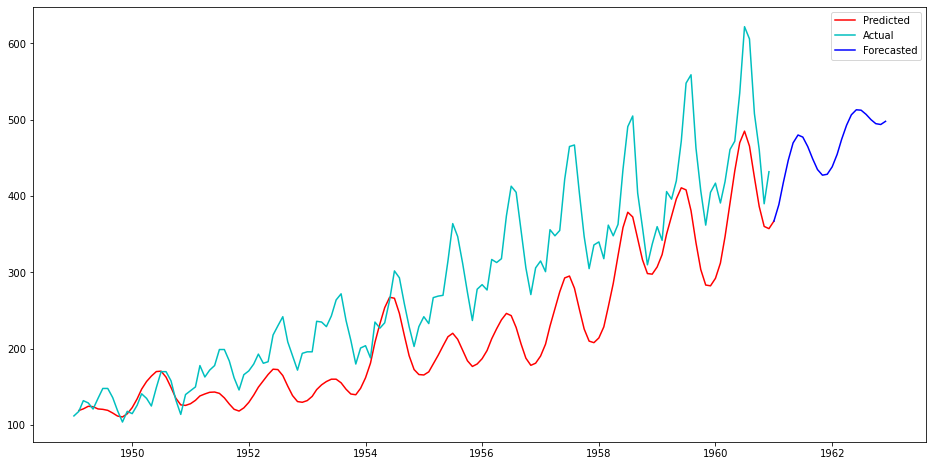

In [46]:
#Visualizing the forecasted values
plt.figure(figsize=(16,8))
plt.plot(forecasted_ARMA.loc[:'1961-01-01'], label = 'Predicted', color = 'r')   #use the forecasted values till 1960-12-01
plt.plot(df['# Passengers'], label = 'Actual', color = 'c')
plt.plot(forecasted_ARMA.loc['1961-01-01':], color = 'b', label = 'Forecasted')   #use the forecasted values from 1961-01-01 to 1962-12-01
plt.legend()
plt.show()

**Observations:**
- Predictions are close to original data series but not very accurate.
- Forecast shows continued growth over the next 2 years.

**End**
******************************************

The part below is not part of the project requirements.
The Dickey Fuller test shows that df_log_diff is stationary with 95% confidence and is a better candidate for fitting AR, MA and ARMA models. Below I make the predictions and forecast with this series.

In [47]:
# MAvg = mean of log series over rolling window of 12 months.
# First 11 values are NaN
MAvg = MAvg.dropna()

In [48]:
# Fit linear model to MAvg
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lr = LinearRegression()
X = np.asarray(pd.to_datetime(MAvg.index).map(datetime.toordinal)).reshape(-1,1)
y = MAvg['# Passengers']
lr.fit(X, y)

LinearRegression()

In [49]:
# This linear model of MAvg will be used to convert log diff time series back to original time series
lr.coef_, lr.intercept_

(array([0.00033254]), -231.8329815811943)

In [50]:
# R2 score shows linear assumption is valid
# This model can be used for forecasting for a short time but not for a long time frame into the future 
# since the linear assumption may not hold for long into the future
ypred = lr.predict(X)
r2_score(y, ypred)

0.9880442863942152

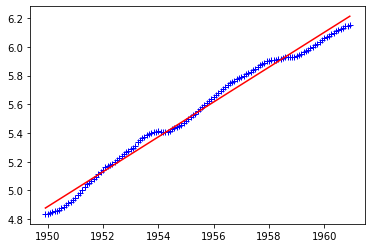

In [51]:
# Plot of moving average and linear fit
plt.plot(MAvg.index, y, '+b')
plt.plot(MAvg.index, ypred, '-r')

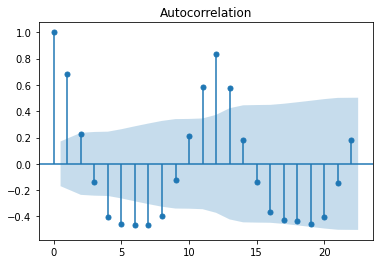

In [52]:
plot_acf(df_log_diff)
plt.show()

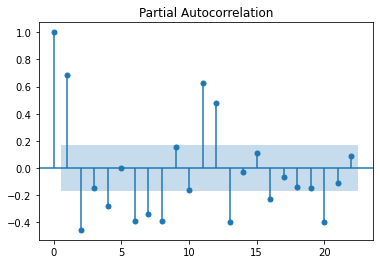

In [53]:
plot_pacf(df_log_diff)
plt.show()

C:\Users\Aruna\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


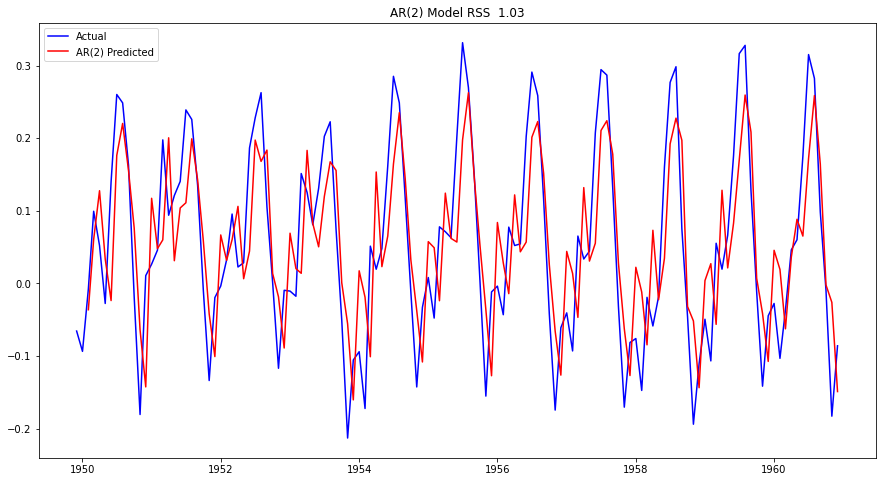

In [54]:
# p=2, q=2

# AR model with p=2

modar = AutoReg(df_log_diff, lags=2)
modar_res = modar.fit()
modar_pred = modar_res.predict(start=0, end=len(df_log_diff)-1)
plt.figure(figsize=(15,8))
plt.plot(df_log_diff, label='Actual', color='b')
plt.plot(modar_pred, label='AR(2) Predicted', color='r')
plt.legend()
modar_pred = modar_pred.fillna(0)
plt.title('AR(2) Model RSS  {:.2f}'.format(sum((modar_pred-df_log_diff['# Passengers'])**2)))
plt.show()

C:\Users\Aruna\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


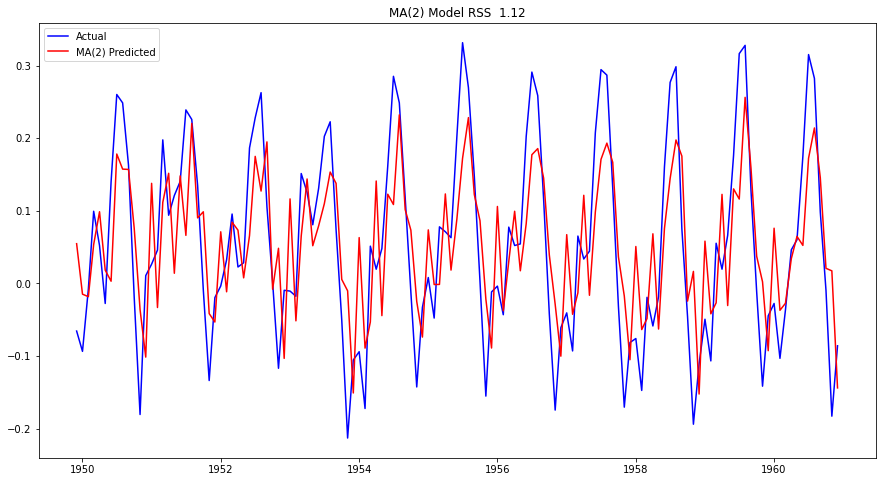

In [55]:
# MA model with q=2

modma = ARMA(df_log_diff, (0,2))
modma_res = modma.fit()
plt.figure(figsize=(15,8))
plt.plot(df_log_diff, label='Actual', color='b')
plt.plot(modma_res.fittedvalues, label='MA(2) Predicted', color='r')
plt.legend()
plt.title('MA(2) Model RSS  {:.2f}'.format(sum((modma_res.fittedvalues-df_log_diff['# Passengers'])**2)))
plt.show()

C:\Users\Aruna\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


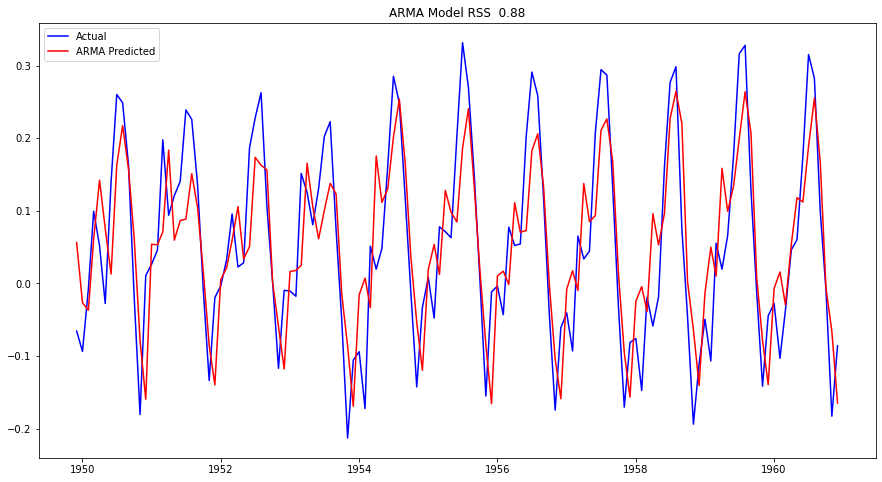

In [56]:
# ARMA model with p=2, q=2

modarma = ARMA(df_log_diff, (2,2))
modarma_res = modarma.fit()
plt.figure(figsize=(15,8))
plt.plot(df_log_diff, label='Actual', color='b')
plt.plot(modarma_res.fittedvalues, label='ARMA Predicted', color='r')
plt.legend()
plt.title('ARMA Model RSS  {:.2f}'.format(sum((modarma_res.fittedvalues-df_log_diff['# Passengers'])**2)))
plt.show()


The ARMA model has the lowest error. The predictions and forecast below are based on this model.

In [57]:
# Predictions from ARMA model
predicted2 = pd.Series(modarma_res.fittedvalues)
predicted2.head()

Year-Month
1949-12-01    0.056344
1950-01-01   -0.026575
1950-02-01   -0.036694
1950-03-01    0.061120
1950-04-01    0.142173
dtype: float64

In [58]:
# Add back moving average from linear regression model

X2 = np.asarray(pd.to_datetime(predicted2.index).map(datetime.toordinal)).reshape(-1,1)
ypred2 = lr.predict(X2) # predicted moving average

In [59]:
mvavgpred2 = pd.Series(ypred2, index=predicted2.index)
predlog2 = predicted2 + mvavgpred2

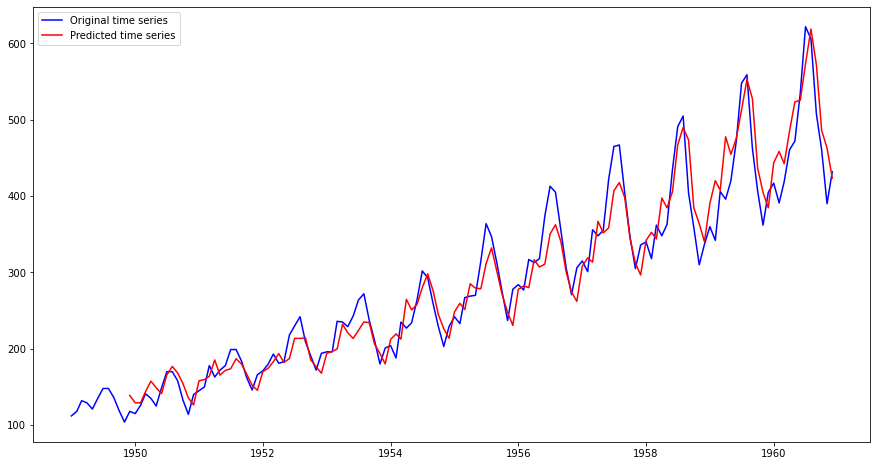

In [60]:
predseries2 = np.exp(predlog2) # predicted time series
# plot
plt.figure(figsize=(15,8))
plt.plot(df, label='Original time series', color='b')
plt.plot(predseries2, label='Predicted time series', color='r')
plt.legend()
plt.show()

In [61]:
# Forecast for next 24 months
forecastlg2 = modarma_res.forecast(steps=24)[0]

# Last date of prediction
pred2_lst = predseries2.index[predseries2.index.shape[0]-1]

In [62]:
# Generate date range for forecast
fc2dates = pd.date_range(start=pred2_lst, periods=24, freq='1M') + pd.offsets.MonthBegin(1)

In [63]:
# Add back moving average term to the forecast

# Predict moving average from linear regression model
Xf2 = np.array(fc2dates.map(datetime.toordinal)).reshape(-1,1)
yf2 = lr.predict(Xf2)

# Add back moving average
forecastlg2wavg = forecastlg2 + yf2

# Transform back from log
forecast2 = np.exp(forecastlg2wavg)  

# Make a Pandas series for the forecast
fcseries2 = pd.Series(forecast2, index=fc2dates)


In [64]:
# Forecasted time series
fcseries2

1961-01-01    493.988746
1961-02-01    532.189885
1961-03-01    566.127579
1961-04-01    588.997780
1961-05-01    597.064862
1961-06-01    593.140219
1961-07-01    582.590997
1961-08-01    571.979689
1961-09-01    565.644174
1961-10-01    565.585591
1961-11-01    572.203869
1961-12-01    583.542724
1962-01-01    597.512622
1962-02-01    611.313275
1962-03-01    622.286819
1962-04-01    630.678731
1962-05-01    635.817040
1962-06-01    639.123793
1962-07-01    641.538335
1962-08-01    644.735598
1962-09-01    649.322168
1962-10-01    655.354172
1962-11-01    663.049992
1962-12-01    671.433423
dtype: float64

In [65]:
# Combine the predicted and forecasted pandas series

predfc2 = pd.concat([predseries2, fcseries2], axis=0)
predfc2

1949-12-01    138.879375
1950-01-01    129.152702
1950-02-01    129.177294
1950-03-01    143.783813
1950-04-01    157.538852
                 ...    
1962-08-01    644.735598
1962-09-01    649.322168
1962-10-01    655.354172
1962-11-01    663.049992
1962-12-01    671.433423
Length: 157, dtype: float64

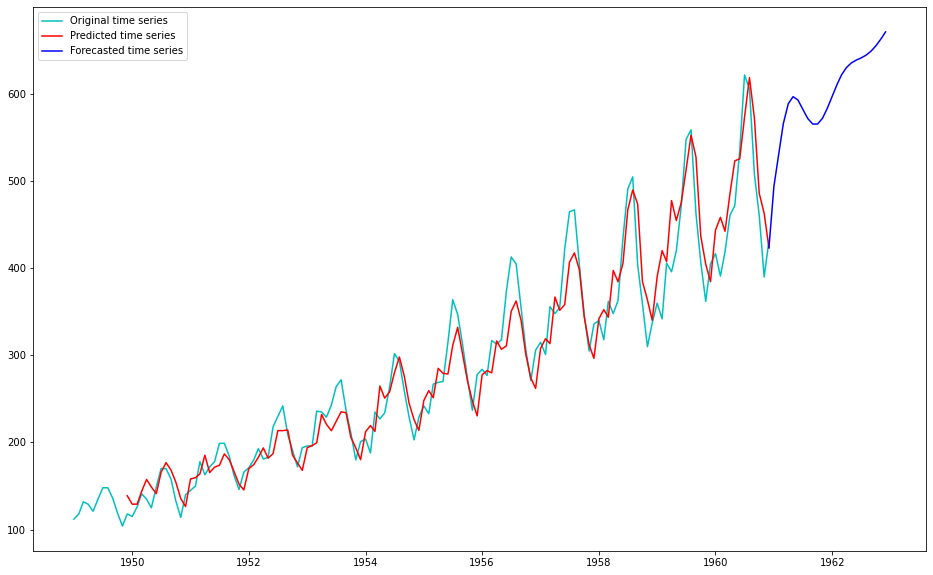

In [66]:
# Plot
plt.figure(figsize=(16,10))
plt.plot(df, label='Original time series', color='c')
plt.plot(predfc2.loc[:pred2_lst], label='Predicted time series', color='r')
plt.plot(predfc2.loc[pred2_lst:], label='Forecasted time series', color='b')
plt.legend()
plt.show()

This model, based on subtracting the moving average from the log series, gives a better prediction and forecast than the shifted log model.